In [38]:
# Read file which has format:
# {"params": "{'ds': 'two-circles', 'n': 1000, 'eps': 0.2, 'k': 2}", "result": {"gen_time": 0.0011019706726074219, "coreset_time": 3.4044859409332275, "coreset_size": 1000, "kmeans_time": 0.0034589767456054688, "kmeans_rounds": 24, "precision": 0.998, "recall": 0.997996000016032, "fmeasure": 0.997998000004008, "rand": 0.998, "jaccard": 0.996004}}

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Each line is stored as:
# file.write(f"{params}: {result}\n")

df = pd.read_csv("results.csv", sep=",")
    
df

,run_id,algorithm,stochasticity,discount_factor,learning_rate,epsilon,episode_length_mc,grid_name,reward_function,cumulative_reward,step,episode
0,1c1bc7e4-0ae2-4c37-968f-381c87080763,Monte Carlo,0.0,0.99,0.408248,0.999500,500,grid_configs\A1_grid.npy,Default,-1132,500,0
1,1c1bc7e4-0ae2-4c37-968f-381c87080763,Monte Carlo,0.0,0.99,0.106600,0.950742,500,grid_configs\A1_grid.npy,Default,-725,40176,100
2,1c1bc7e4-0ae2-4c37-968f-381c87080763,Monte Carlo,0.0,0.99,0.094491,0.904362,500,grid_configs\A1_grid.npy,Default,-1008,67923,200
3,1c1bc7e4-0ae2-4c37-968f-381c87080763,Monte Carlo,0.0,0.99,0.083624,0.860245,500,grid_configs\A1_grid.npy,Default,8,92991,300
4,1c1bc7e4-0ae2-4c37-968f-381c87080763,Monte Carlo,0.0,0.99,0.063246,0.818280,500,grid_configs\A1_grid.npy,Default,-928,115331,400
...,...,...,...,...,...,...,...,...,...,...,...,...
925,93d227b7-13fc-40ea-8f95-456f047ec545,Monte Carlo,0.1,0.90,0.004096,0.105287,500,grid_configs\A1_grid.npy,Default,-512,1164553,4500
926,93d227b7-13fc-40ea-8f95-456f047ec545,Monte Carlo,0.1,0.90,0.025416,0.100151,500,grid_configs\A1_grid.npy,Default,8,1181468,4600
927,93d227b7-13fc-40ea-8f95-456f047ec545,Monte Carlo,0.1,0.90,0.003904,0.095265,500,grid_configs\A1_grid.npy,Default,-520,1201202,4700
928,93d227b7-13fc-40ea-8f95-456f047ec545,Monte Carlo,0.1,0.90,0.039528,0.090618,500,grid_configs\A1_grid.npy,Default,0,1223450,4800


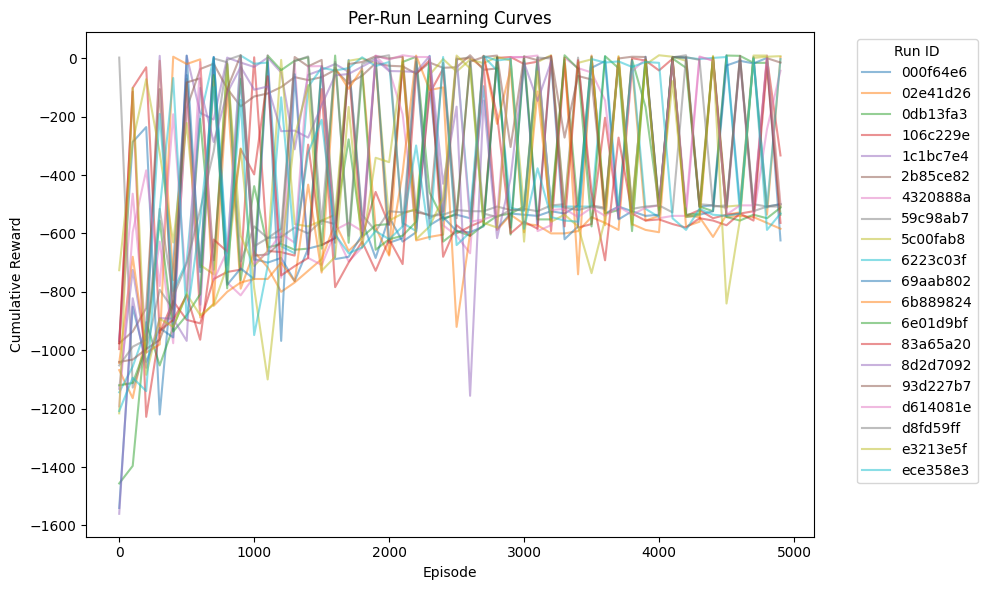

In [43]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 2) Plot each run_id as a separate line
plt.figure(figsize=(10, 6))
for run_id, run_df in df.groupby('run_id'):
    plt.plot(
        run_df['episode'],
        run_df['cumulative_reward'],
        label=str(run_id)[:8],  # truncate for readability
        alpha=0.5
    )
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Per-Run Learning Curves')
plt.legend(title='Run ID', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


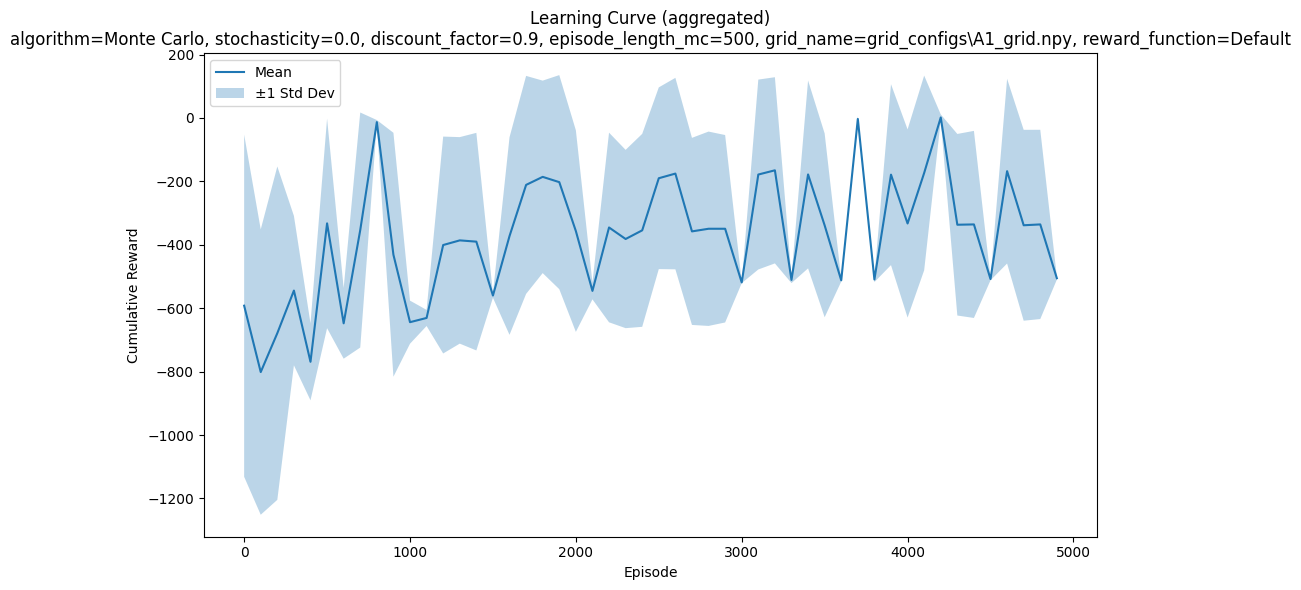

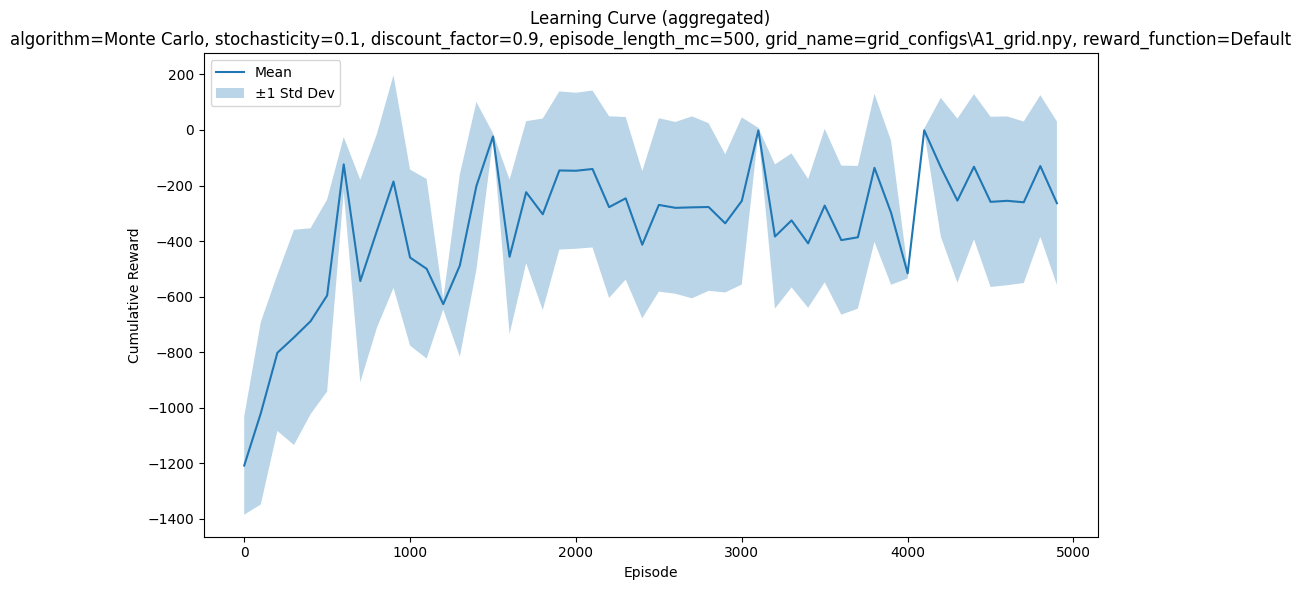

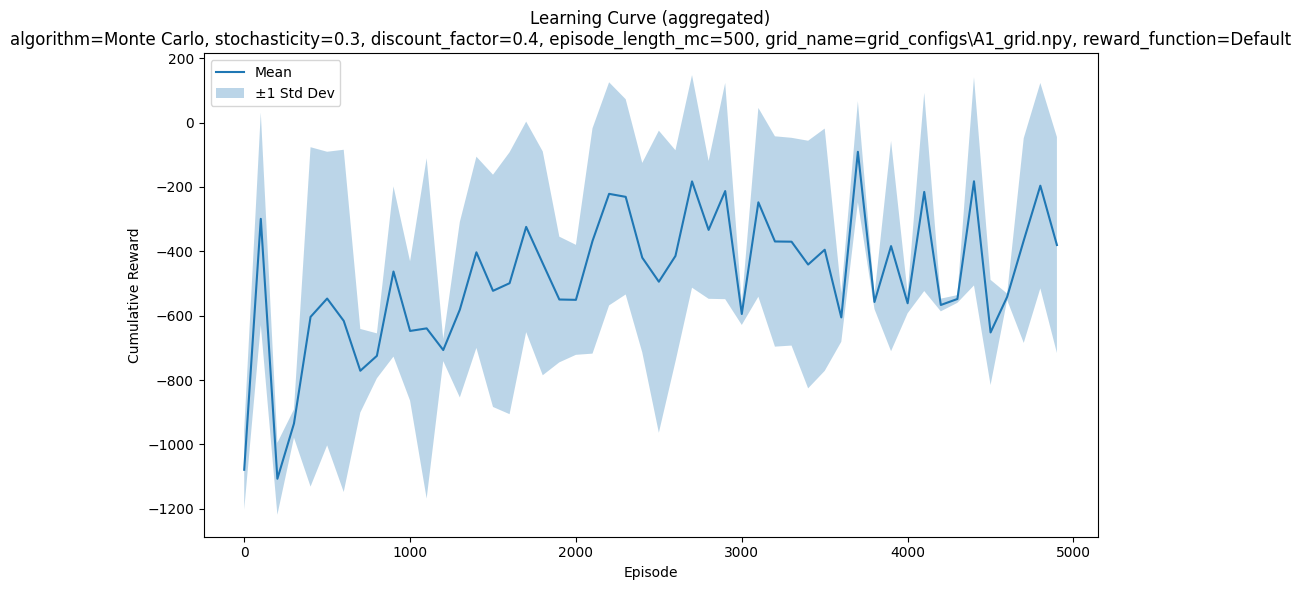

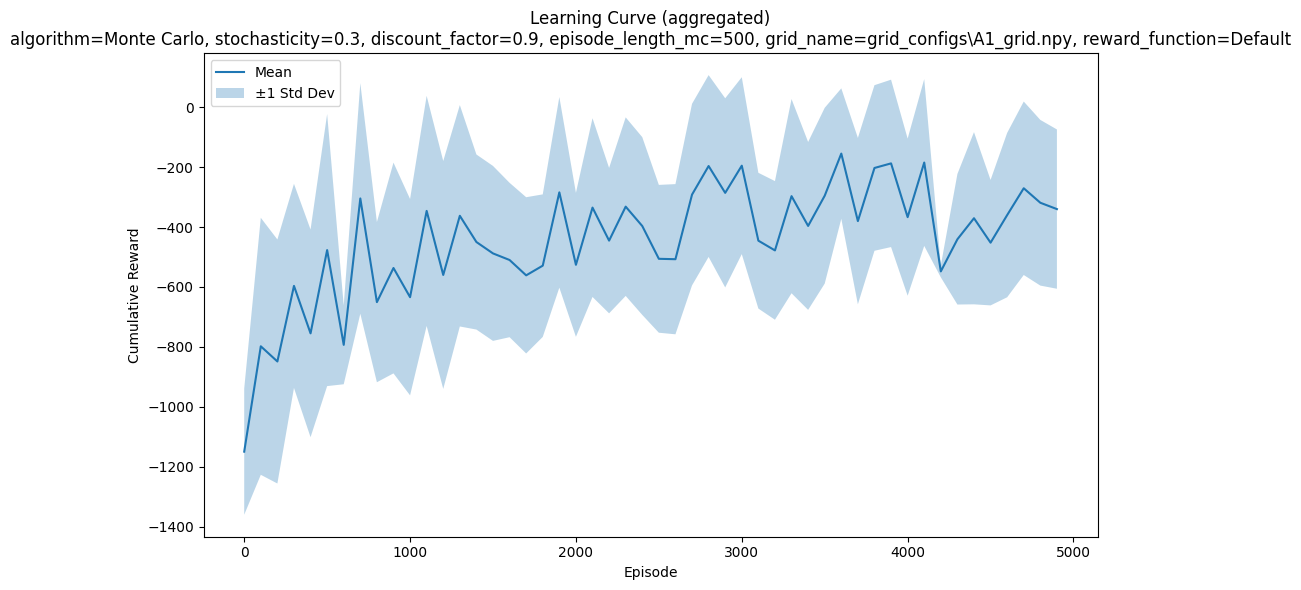

In [40]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 3) Aggregate: only group on the *static* hyper‑params, not on epsilon
param_cols = [
    'algorithm',
    'stochasticity',
    'discount_factor',
    'episode_length_mc',
    'grid_name',
    'reward_function'
]

agg_plots = {}
for params, grp in df.groupby(param_cols):
    # pivot: index=episode, columns=run_id, values=cumulative_reward
    wide = grp.pivot_table(
        index='episode',
        columns='run_id',
        values='cumulative_reward'
    ).sort_index()

    # skip any tiny groups just in case
    if wide.shape[1] < 2:
        continue

    agg_plots[params] = wide

# 4) Plot mean ± std for each parameter‑set
for params, wide in agg_plots.items():
    mean_series = wide.mean(axis=1)
    std_series  = wide.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_series.index, mean_series, label='Mean')
    plt.fill_between(
        mean_series.index,
        mean_series - std_series,
        mean_series + std_series,
        alpha=0.3,
        label='±1 Std Dev'
    )

    param_str = ', '.join(f'{k}={v}' for k, v in zip(param_cols, params))
    plt.title(f'Learning Curve (aggregated)\n{param_str}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()
